In [1]:
import json
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
matplotlib.rcParams["font.sans-serif"] = ["SimHei"]

In [3]:
class Jwc:
    """
    教务处门户网站的基础操作类
    """

    headers = """
Host: jwc.xjtu.edu.cn
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8
Accept-Language: zh-CN
Accept-Encoding: gzip, deflate, br
Connection: keep-alive
Cookie: _ga=GA1.3.1956469236.1693923250; JSESSIONID=2FD9EC49EB3B9BE4EF26B758AC164DD8
Upgrade-Insecure-Requests: 1
Sec-Fetch-Dest: document
Sec-Fetch-Mode: navigate
Sec-Fetch-Site: cross-site
"""

    def __init__(self):
        """
        初始化一个教务网站访问器
        """
        self.headers = {}
        for i in Jwc.headers.strip().split("\n"):
            j = i.split(": ")
            self.headers[j[0]] = j[1]
        self.response = requests.get("https://jwc.xjtu.edu.cn", headers=self.headers)
        self.response.encoding = "utf-8"
        self.soup = BeautifulSoup(self.response.text, "lxml")

    def notice_board(self):
        """
        返回教务处主页的通知面板消息DataFrame
        """
        data = pd.DataFrame(columns=["类型", "标题", "时间", "链接"])
        for a in self.soup.select("ul.wow")[0].find_all("a"):
            data.loc[len(data)] = {
                "类型": a.i.text[1:-1],
                "标题": a.attrs["title"],
                "时间": pd.to_datetime(a.next_sibling.text),
                "链接": "https://jwc.xjtu.edu.cn/" + a.attrs["href"],
            }
        return data

    def all_notice(self, l, r):
        """
        获取https://jwc.xjtu.edu.cn/jxxx/jxtz2/x.htm的[l, r)区间页数所有通知
        """
        data = pd.DataFrame(columns=["类型", "标题", "时间", "链接"])
        i = 1
        for i in range(l, r):
            r = requests.get(
                f"https://jwc.xjtu.edu.cn/jxxx/jxtz2/{i}.htm", headers=self.headers
            )
            r.encoding = "utf-8"
            if "404错误提示" in r.text:
                break
            s = BeautifulSoup(r.text, "lxml")
            for a in s.select("ul.wow")[0].find_all("a"):
                data.loc[len(data)] = {
                    "类型": a.i.text[1:-1],
                    "标题": a.i.next_sibling,
                    "时间": pd.to_datetime(a.next_sibling.text),
                    "链接": "https://jwc.xjtu.edu.cn/" + a.attrs["href"][6:],
                }
        return data

In [4]:
class NoticePage:
    """
    教务处教学通知网页迭代器
    """

    headers = """
Host: jwc.xjtu.edu.cn
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8
Accept-Language: zh-CN
Accept-Encoding: gzip, deflate, br
Connection: keep-alive
Cookie: _ga=GA1.3.1956469236.1693923250; JSESSIONID=2FD9EC49EB3B9BE4EF26B758AC164DD8
Upgrade-Insecure-Requests: 1
Sec-Fetch-Dest: document
Sec-Fetch-Mode: navigate
Sec-Fetch-Site: cross-site
"""

    def __init__(self):
        """
        初始化一个指向教学通知第一页的迭代器
        """
        self.headers = {}
        for i in Jwc.headers.strip().split("\n"):
            j = i.split(": ")
            self.headers[j[0]] = j[1]
        r = requests.get("https://jwc.xjtu.edu.cn", headers=self.headers)
        r.encoding = "utf-8"
        s = BeautifulSoup(r.text, "lxml")
        div = s.find("div", class_="more")
        self.url = "https://jwc.xjtu.edu.cn/" + div.a.attrs["href"]
        # print(self.url)
        self.response = requests.get(self.url, headers=self.headers)
        self.response.encoding = "utf-8"

    def next(self, t=1):
        """
        使迭代器向后移动t页（默认1页）
        """
        for i in range(t):
            self.url = (
                os.path.split(self.url)[0]
                + "/"
                + re.search(
                    r'<span class="p_next p_fun"><a href="(.*?)">下页</a></span><span class="p_last p_fun">',
                    self.response.text,
                ).group(1)
            )
            self.response = requests.get(self.url, headers=self.headers)
            self.response.encoding = "utf-8"
        return self

    def previous(self, t=1):
        """
        使迭代器向前移动t页（默认1页）
        """
        for i in range(t):
            self.url = (
                os.path.split(self.url)[0]
                + "/"
                + re.search(
                    r'<span class="p_prev p_fun"><a href="(.*?)">上页</a></span>',
                    self.response.text,
                ).group(1)
            )
            self.response = requests.get(self.url, headers=self.headers)
            self.response.encoding = "utf-8"
            self.url = self.response.url
        return self

    def content(self):
        """
        返回当前网页所有教学通知DataFrame
        """
        data = pd.DataFrame(columns=["类型", "标题", "时间", "链接"])
        i = 1
        s = BeautifulSoup(self.response.text, "lxml")
        for a in s.select("ul.wow")[0].find_all("a"):
            data.loc[len(data)] = {
                "类型": a.i.text[1:-1],
                "标题": a.i.next_sibling,
                "时间": pd.to_datetime(a.next_sibling.text),
                "链接": "https://jwc.xjtu.edu.cn/" + a.attrs["href"][6:],
            }
        return data

In [5]:
class NoticeList:
    """
    处理所有通知DataFrame的函数库
    """

    def __init__(self):
        """
        初始化一个空表
        """
        self.data = pd.DataFrame(columns=["类型", "标题", "时间", "链接"])

    def append(self, data):
        """
        将通知DataFrame data 添加进当前表，并返回
        """
        self.data = pd.concat([self.data, data], axis=0, ignore_index=True)
        return self.data

    def drop_duplicates(self):
        """
        删除表中的相同行，并返回表
        """
        self.data.drop_duplicates(subset=["链接"], inplace=True)
        return self.data

    def statistics(self, col):
        """
        按col统计并返回统计出的字典
        """
        d = {}
        for i, r in L.data.iterrows():
            d.setdefault(r[col], 0)
            d[r[col]] += 1
        return d

    def plot(self, col):
        """
        按col统计绘制plot图
        """
        d = self.statistics(col)
        plt.plot(d.keys(), d.values())
        plt.xticks(rotation=90)

    def bar(self, col):
        """
        按col统计绘制bar图
        """
        d = self.statistics(col)
        plt.bar(d.keys(), d.values())
        plt.xticks(rotation=90)

    def pie(self, col):
        """
        按col统计绘制pie图
        """
        d = self.statistics(col)
        plt.pie(d.values(), labels=d.keys(), autopct="%.1f%%")

In [6]:
n = NoticePage()
L = NoticeList()
for i in range(20):
    L.append(n.content())
    n.next()

C:\Users\a\AppData\Local\Temp\ipykernel_8324\2157080115.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, data], axis=0, ignore_index=True)


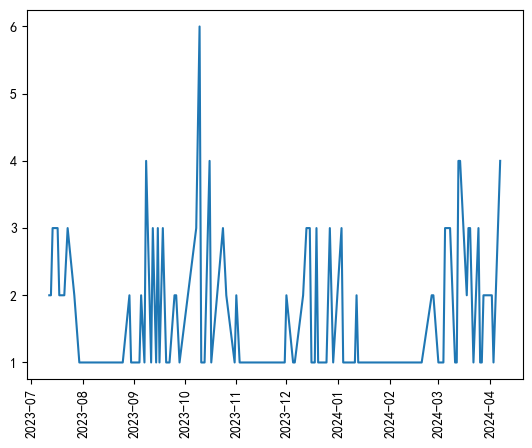

In [7]:
L.plot("时间")

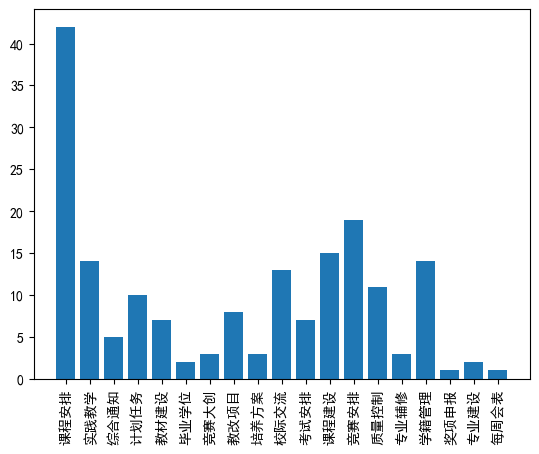

In [8]:
L.bar("类型")

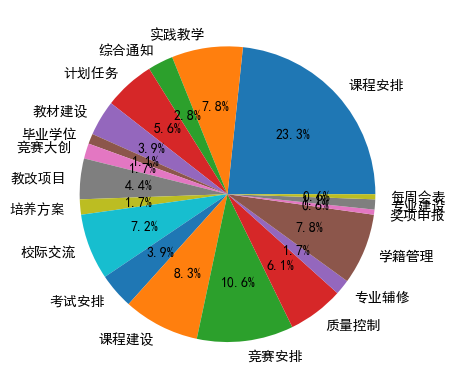

In [9]:
L.pie("类型")

In [10]:
L.data.to_csv("data.csv")